# Thermodynamic parameters of Zika Sensors

## Importing usefull packages and definition of funcions

In [156]:
import os
import os.path
from subprocess import Popen, PIPE
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
from skbio import Sequence

In [2]:
def reversed_complement(sequence):
    mapping = {'A': 'U', 'G': 'C', 'U': 'A', 'C': 'G'}
    sequence_upper = sequence.upper()

    complement = ''
    for c in sequence_upper:
        complement += mapping[c]

    # reverse the sequence
    return complement[::-1]

In [3]:
def split_sequence(sequence, window):
    sequences = []
    limit = len(sequence) - window + 1

    for i in range(0, limit):
        sequences.append(sequence[i:window + i])

    return sequences

In [4]:
# Calculation of the minimum free energy (MFE) secondary structure of a singular RNA sequence

def DG(sequence,result_path,wait):
    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()
    final=[]
    semi_final=[]

    Popen(["mfe -T 23 {}pipo".format(result_path)],shell=True, stdout=PIPE)
    time.sleep(wait)
    lenght=len(sequence)
    with open("{}pipo.mfe".format(result_path)) as res:
        for r in res:
            r = r.strip('\n')
            if not r.startswith('%'):
                r = r.split('\t')
                semi_final.append(r)

    #final.append()                

    return (float(semi_final[2][0]))

    os.remove("{}pipo.mfe".format(result_path,))
    os.remove("{}pipo.in".format(result_path))


In [5]:
# Calculation of the minimum free energy (MFE) secondary structure of a complex formed out of two equimolar RNA sequences
def DG_2(sequence1, sequence2, result_path,wait):
    
    
    file = open("{}Pipe.in".format(result_path), 'w')
    file.write("{}\n".format("2"))
    file.write("{}\n".format(sequence1))
    file.write("{}\n".format(sequence2))
    file.write("{}\n".format("1 2"))
    file.close()

    semi_final=[]
    Popen(["mfe -multi {}Pipe".format(result_path)],shell=True, stdout=PIPE)
    time.sleep(wait)
    #lenght=len(sequence)
    with open("{}Pipe.mfe".format(result_path)) as res:
        for r in res:
            r = r.strip('\n')
            if not r.startswith('%'):
                r = r.split('\t')
                semi_final.append(r)
    os.remove("{}Pipe.in".format(result_path))
    os.remove("{}Pipe.mfe".format(result_path))            
    return (float(semi_final[2][0]))

In [6]:

def norm_Toehold_single_streadness(sequence, result_path, wait=1):
    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

        
    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    sin=parsed_res
    
    toehold=sin[0:24]
    single=(np.sum(toehold)/len(toehold))
    return single

In [7]:

def norm_single_streadness(sequence, result_path, wait=1):
    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

        
    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    sin=parsed_res
    
    #toehold=sin[0:24]
    #single=np.sum(single)/len(single))
    single=(np.sum(sin)/len(sin))


    return single

In [8]:
def parse_pairs_result(res, length):
    final = []
    for r in res:
        r = r.strip('\n')
        if not r.startswith('%'):
            r = r.split('\t')
            if len(r) == 3:
                if r[1] == str(length+1):
                    final.append(float(r[2]))

    return final

In [9]:

def complex_defect(sequence, secondary, result_path):
    file = open('{}toeh.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.write("{}".format(secondary))
    file.close()

    defect_toeh = 0
    count = 0
    with Popen(["complexdefect", "{}toeh".format(result_path)], stdout=PIPE) as proc:
        res = (proc.stdout.read()).decode("utf-8").split('\n')
        for l in res:
            count += 1
            if count == 16:
                defect_toeh = float(l)

    os.remove("{}toeh.in".format(result_path))
    return defect_toeh

In [10]:

def complex_defect_2(sequenceA,sequenceB, secondary, result_path,wait):
    file = open("{}toeh.in".format(result_path), 'w')
    file.write("{}\n".format("2"))
    file.write("{}\n".format(sequenceA))
    file.write("{}\n".format(sequenceB))
    file.write("{}\n".format("1 2"))
    file.write("{}\n".format(secondary))
    file.close()

    defect_toeh = 0
    count = 0
    with Popen(["complexdefect -multi {}toeh".format(result_path)],shell=True, stdout=PIPE) as proc:
        time.sleep(wait)
     
    
        res= (proc.stdout.read()).decode("utf-8").split('\n')
        for l in res:
            count += 1
            if count == 16:
                defect_toeh = float(l)        
    #print ('STDOUT:{}'.format(stdout))
    #output = process.stdout.readline()
    #process.poll()
    
    #a=stdout.splitlines()
    
    os.remove("{}toeh.in".format(result_path))
    
    #return res[-2]
    return defect_toeh


In [11]:

def all_single_streadness(sequence, result_path, wait=1):
    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    sin=parsed_res
    


    return sin

In [12]:

def ss_in_context(sequence,sub_sequence,result_path, wait=1):
    s = Sequence(sequence)
    initial=s.index(sub_sequence)

    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    
    
    sin=parsed_res[initial:initial+len(sub_sequence)]
    norm=(np.sum(sin)/len(sin))


    return norm

## Loadding results

In [13]:
#Read results
Serie_A=pd.read_csv("Serie_A.csv")
Serie_A['Serie'] = 'Serie A'


In [14]:
#Read results
Serie_B=pd.read_csv("Serie_B.csv")
#a["Sensor"]=ind
Serie_B['Serie'] = 'Serie B'

In [15]:
#Concatenate the two dataframes
frames=[Serie_A,Serie_B]
result_2 = pd.concat(frames)
result_2;


## Comparison of Series A and Series B 

#### Avegage ON/Off rate distributions of Series A and  B are similar but higher values are observed in Series B. Also, both series have several sensors that show poor ON-OFF rate, which indicates a low probability of succes in the design of effective sensors. Also in ZIka's paper, they showed that Series B popultion have lower background than Series A.

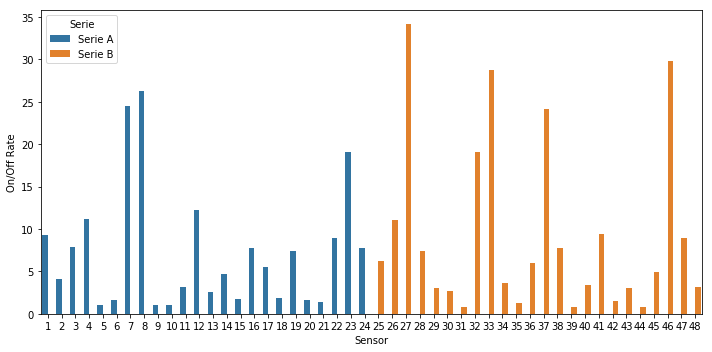

In [16]:

f, ax = plt.subplots(figsize=(10,5))

sns.barplot(x=result_2.Sensor,y=result_2.iloc[:,1],hue=result_2.Serie)
plt.tight_layout()


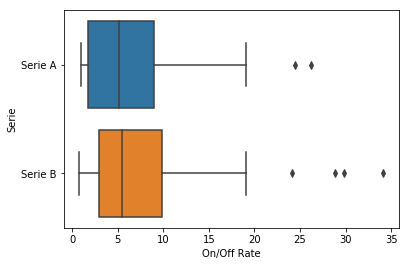

In [17]:
sns.boxplot(x=result_2.iloc[:,1],y=result_2.Serie)

## Calculating thermodynamic parameters of Series B sensors 


### Parameter definitions:
#### Dg_Switch: is the Free Energy of the longer switch RNA composing the first 97 nt after the GGG leadder sequence.
#### Dg_Trigger: is the Free Energy of the entire trigger RNA composing 36 nt that bind to the toehold domain and the displacement sequence
#### Single_Streadness_Trigger: Is the normalized single streadness of the trigger RNA
#### Dg_RBS_linker: Represents the minimum free energy (MFE) secondary structure of the sequence between the RBS until the start of the "linker" nucleotide position 47 until 9.
#### Trigger_Deffect: Represents the average number of paired nucleotides at equilibrium in the trigger RNA. This is a quantification of a "normalized defect", because the trigger optimal design is a perfectlly single stranded sequence.
#### Sensor_Defect: representing the average number of incorrectly paired nucleotides at equilibrium evaluated over the ensemble of the complex 
#### sensor designed structure: ".........................(((((((((((...(((((............)))))...)))))))))))......................"
#### sensor+trigger complex designed structure: ".......................................(((((............)))))....................................+...................................."


In [18]:
Dg_Switch=[]
for i in range(len(Serie_B.iloc[:,2])):
    Dg_Switch.append(DG(Serie_B.iloc[i,2],"Temp/",1))
P1=pd.Series(Dg_Switch)
Serie_B["DeltaG_Switch"]=P1.values

In [19]:
Dg_trigger=[]
for i in range(len(Serie_B.iloc[:,3])):
    Dg_trigger.append(DG(Serie_B.iloc[i,3],"Temp/",1))
P2=pd.Series(Dg_trigger)
Serie_B["DeltaG_Trigger"]=P2.values

In [20]:
SS_Trigger=[]
for i in range(len(Serie_B.iloc[:,3])):
    SS_Trigger.append(norm_single_streadness(Serie_B.iloc[i,3],"Temp/",2))
P3=pd.Series(SS_Trigger)
Serie_B["Single_Streadness_Trigger"]=P3.values

In [21]:
Dg_RBS_linker=[]
for i in range(len(Serie_B.iloc[:,3])):
    RBS_linker=Serie_B.iloc[i,2][48:96]
    Dg_RBS_linker.append(DG(RBS_linker,"",2))
P4=pd.Series(Dg_RBS_linker)
Serie_B["Dg_RBS_linker"]=P4.values

In [22]:
dTrigger=[]
for i in range(len(Serie_B.iloc[:,8])):
    dTrigger.append(1-Serie_B.iloc[i,8])
P5=pd.Series(dTrigger)
Serie_B["Trigger_Deffect"]=P5.values

sensor_des_structure=".........................(((((((((((...(((((............)))))...)))))))))))......................"

Sensor_Defect=[]
for i in range(len(Serie_B.iloc[:,2])): 
    Sensor_Defect.append(complex_defect(Serie_B.iloc[i,2],sensor_des_structure,"Temp/"))
P6=pd.Series(Sensor_Defect)
Serie_B["Sensor_Defect"]=P6.values

In [23]:
dToehold=[]
for i in range(len(Serie_B.iloc[:,8])):
    dToehold.append(1-norm_Toehold_single_streadness(Serie_B.iloc[i,2],"",2))
P7=pd.Series(dToehold)
Serie_B["Toehold_Deffect"]=P7.values

In [24]:
# this is the structure of the designed optimal interaction betwen a Sensor and its trigger
secondary_2=".......................................(((((............)))))....................................+...................................."

In [27]:
Complex_Defect=[]
for i in range(len(Serie_B.iloc[:,2])): 
    Complex_Defect.append(complex_defect_2(Serie_B.iloc[i,2],Serie_B.iloc[i,3], secondary_2,"",10))
P8=pd.Series(Complex_Defect)
Serie_B["Complex_Defect"]=P8.values

In [28]:
dBIndingSite=[]
for i in range(len(Serie_B.iloc[:,2])): 
    dBIndingSite.append(1-ss_in_context(Serie_B.loc[i,"Amplification sequence"],Serie_B.loc[i,"Trigger Sequence"],"",10))
P9=pd.Series(dBIndingSite)
Serie_B["dBIndingSite"]=P9.values


In [128]:
Serie_B

,Sensor,On/Off Rate,Sensor Sequence,Trigger Sequence,Amplification sequence,Serie,DeltaG_Switch,DeltaG_Trigger,Single_Streadness_Trigger,Dg_RBS_linker,Trigger_Deffect,Sensor_Defect,Toehold_Deffect,Complex_Defect,dBIndingSite
0,25,6.186667,UCUUCAGCCUCCAUGUGUCAUUCUUCUCACUCUCAAGGACUUUAGA...,UUGAGAGUGAGAAGAAUGACACAUGGAGGCUGAAGA,GGGCAGUGAUCUAGGCUACUGGAUUGAGAGUGAGAAGAAUGACACA...,Serie B,-35.551,-3.175,0.820792,-8.469,0.179208,0.1956,0.337686,0.7379,0.357118
1,26,11.093333,AAAUUCCCCUUGUUUCUUUUCUCUUUUUCCCAUCAUGGACUUUAGA...,AUGAUGGGAAAAAGAGAAAAGAAACAAGGGGAAUUU,GGGUGCCAGAGUUGUGUGUACAACAUGAUGGGAAAAAGAGAAAAGA...,Serie B,-31.870,-0.396,0.890751,-7.898,0.109249,0.3662,0.366362,0.6680,0.381049
2,27,34.133333,UUUCGCUCUAUUCUCAUCAGUUUCAUGUCCUGUGUCGGACUUUAGA...,GACACAGGACAUGAAACUGAUGAGAAUAGAGCGAAA,GGGCCAGCACAGUGGGAUGAUCGUUAAUGACACAGGACAUGAAACU...,Serie B,-36.519,-4.615,0.773636,-9.988,0.226364,0.2898,0.518823,0.6821,0.402395
3,28,7.360000,GCUCCCCUUCUACUGAUCUCCACAUGAUGUUUUCCAGGACUUUAGA...,UGGAAAACAUCAUGUGGAGAUCAGUAGAAGGGGAGC,GGGCGGGAUCUCCUCUGUUUCAAGAAUGGAAAACAUCAUGUGGAGA...,Serie B,-30.502,-4.200,0.758035,-14.356,0.241965,0.1605,0.155996,0.7527,0.529241
4,29,2.986667,AACUUCUUUAUUAUUUCCAUAGCCUCUUUUUUCCCCGGACUUUAGA...,GGGGAAAAAAGAGGCUAUGGAAAUAAUAAAGAAGUU,GGGCCAUCACUGGGUCUCAUCAAUAGAUGGGGUUCAGUGGGGAAAA...,Serie B,-30.709,-2.603,0.833765,-7.706,0.166235,0.1528,0.108688,0.6587,0.340184
5,30,2.666667,AGGGUGGCUUCGGCUCUUGGUGAAUUGGGCGUUAUCGGACUUUAGA...,GAUAACGCCCAAUUCACCAAGAGCCGAAGCCACCCU,GGGAAUGCUGUCAGUUCAUGGCUCCCAGCACAGUGGGAUGAUCGUU...,Serie B,-40.821,-3.234,0.810051,-11.621,0.189949,0.2493,0.487520,0.6945,0.537003
6,31,0.746667,CUUCCACUGCAGUCUUCCACUCUUUUUCCUCUUCAAGGACUUUAGA...,UUGAAGAGGAAAAAGAGUGGAAGACUGCAGUGGAAG,GGGAGAAGGAUGGUCUCUUCCUGGUUGUGGAAAGAGCUAGGCAAAC...,Serie B,-35.203,-4.160,0.781046,-9.128,0.218954,0.2569,0.417768,0.7165,0.431669
7,32,19.093333,CUGGGAUCAAGUACAUGUAGUGCGCCACGAGCAAAAGGACUUUAGA...,UUUUGCUCGUGGCGCACUACAUGUACUUGAUCCCAG,GGGCUGACCCUAAUAGUGGCCAUCAUUUUGCUCGUGGCGCACUACA...,Serie B,-33.682,-6.100,0.673751,-13.048,0.326249,0.1892,0.360336,0.7346,0.543570
8,33,28.800000,ACUAUUAGGGUCAGGGGUGUUAAUUGUGAGUAGCAAGGACUUUAGA...,UUGCUACUCACAAUUAACACCCCUGACCCUAAUAGU,GGGUUUGGUAUGGGCAAAGGGAUGCCAUUCUACGCAUGGGACUUUG...,Serie B,-36.733,-1.457,0.819184,-12.105,0.180816,0.2088,0.338471,0.7211,0.472903
9,34,3.626667,CAUCGCCAUUAAGGAGUAGUUGUUGUAUGAGGUGGUGGACUUUAGA...,ACCACCUCAUACAACAACUACUCCUUAAUGGCGAUG,GGGCCAUCUAUGCUGCCUUGACAACUUUCAUUACCCCAGCCGUCCA...,Serie B,-38.465,-1.859,0.829996,-11.527,0.170004,0.2389,0.388249,0.7330,0.397565


## Simple linear regressions

### Until this point, we've calculated thermodynamic parameters of the sensors and triggers, and defects respect to the design goal. Lets see if any of thiese parameters correlates with the ON-OFF responce.

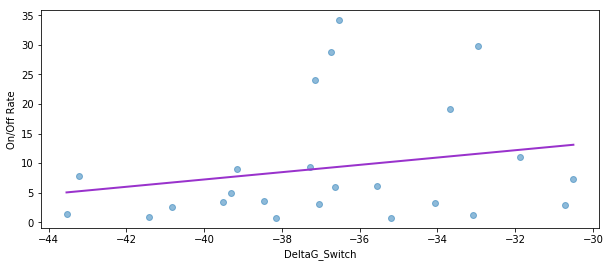

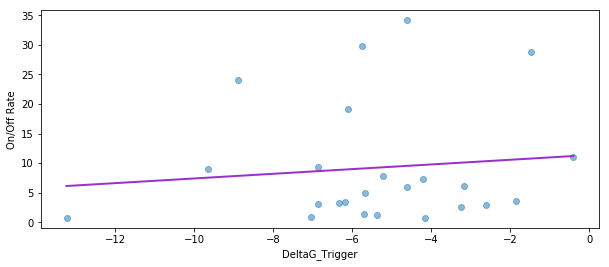

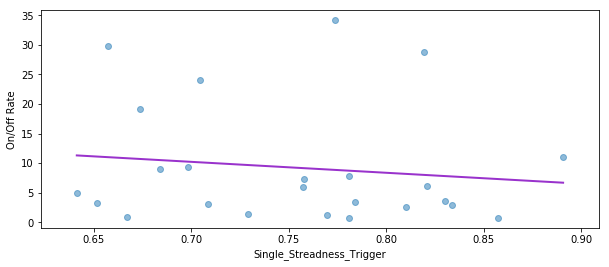

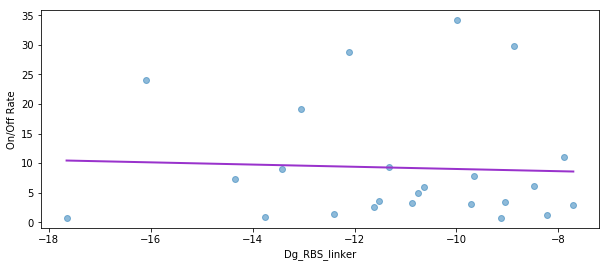

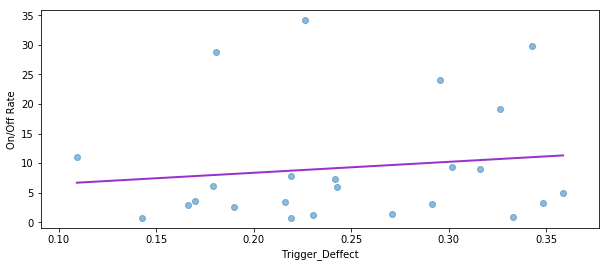

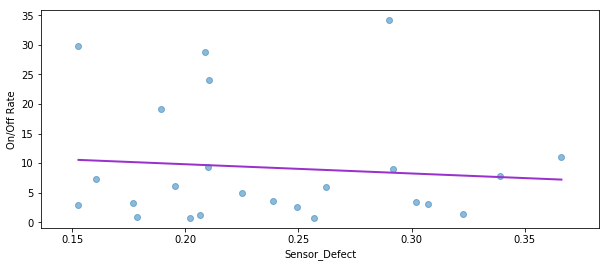

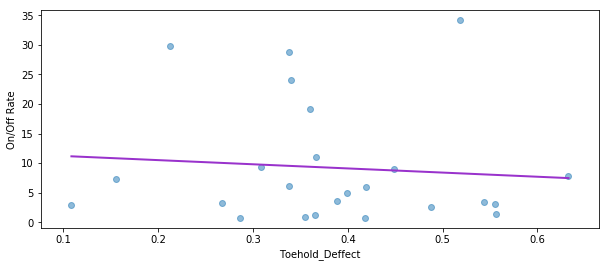

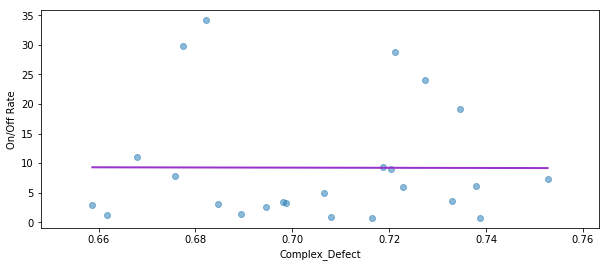

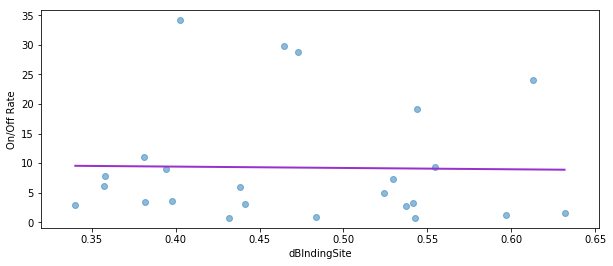

In [34]:
list_of_lists = []
x=0
y=0
name=0
for i in range(6,len(Serie_B.columns)):
    y=Serie_B["On/Off Rate"]
    x=Serie_B[Serie_B.columns[i]]
    name=x.name

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(x.astype(float), y, alpha=0.5)
    plt.xlabel(x.name)
    plt.ylabel(y.name)

    x_pred = np.linspace(x.astype(float).min(), x.astype(float).max(), 50)
    
    x=sm.add_constant(x)
    regression1 = sm.OLS(y, x.astype(float)).fit() 

    x_pred2 = sm.add_constant(x_pred)
    y_pred = regression1.predict(x_pred2)
    ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)

    #x_pred2=0
    #y_pred=0
    list_of_lists.append([name,regression1.rsquared,regression1.params[1],regression1.pvalues[1] ])
out=pd.DataFrame(list_of_lists, columns=['name', 'R-squared',"Linear model Coef","p-value"])


In [35]:
out

,name,R-squared,Linear model Coef,p-value
0,DeltaG_Switch,0.048547,0.617839,0.300867
1,DeltaG_Trigger,0.011631,0.394945,0.615951
2,Single_Streadness_Trigger,0.016843,-18.483702,0.545562
3,Dg_RBS_linker,0.002272,-0.186651,0.824973
4,Trigger_Deffect,0.016843,18.483702,0.545562
5,Sensor_Defect,0.008914,-15.604543,0.660781
6,Toehold_Deffect,0.007884,-7.024718,0.679917
7,Complex_Defect,0.000013,-1.386464,0.986549
8,dBIndingSite,0.000378,-2.265674,0.928184


In [ ]:
list_of_lists = []
x=0
y=0
name=0
for i in range(6,len(Serie_B.columns)):
    y=S_B_norm["On/Off Rate"]
    x=S_B_norm[Serie_B.columns[i]]
    name=x.name

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(x.astype(float), y, alpha=0.5)
    plt.xlabel(x.name)
    plt.ylabel(y.name)

    x_pred = np.linspace(x.astype(float).min(), x.astype(float).max(), 50)
    
    x=sm.add_constant(x)
    regression1 = sm.OLS(y, x.astype(float)).fit() 

    x_pred2 = sm.add_constant(x_pred)
    y_pred = regression1.predict(x_pred2)
    ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)

    #x_pred2=0
    #y_pred=0
    list_of_lists.append([name,regression1.rsquared,regression1.params[1],regression1.pvalues[1] ])
out_norm=pd.DataFrame(list_of_lists, columns=['name', 'R-squared',"Linear model Coef","p-value"])
out_norm



## Multiple linear regressions 

In [175]:
Y.iloc[:,0]

0      6.186667
1     11.093333
2     34.133333
3      7.360000
4      2.986667
5      2.666667
6      0.746667
7     19.093333
8     28.800000
9      3.626667
10     1.280000
11     5.973333
12    24.106667
13     7.786667
14     0.746667
15     3.413333
16     9.386667
17     1.493333
18     3.093333
19     0.853333
20     4.906667
21    29.866667
22     8.960000
23     3.200000
Name: On/Off Rate, dtype: float64

In [197]:
#from sklearn import linear_model

#X = Serie_B[["Sensor_Defect","dBIndingSite","Complex_Defect"]] # here we have 4 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets

X = Serie_B[["Sensor_Defect","dBIndingSite"]]
#Y = np.log(Serie_B[["On/Off Rate"]]) 
Y = (Serie_B[["On/Off Rate"]])

#print('Intercept: \n', regr.intercept_)
#print('Coefficients: \n', regr.coef_)


# with statsmodels
#X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X.astype(float)).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            On/Off Rate   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     8.978
Date:                Tue, 01 Jan 2019   Prob (F-statistic):            0.00141
Time:                        19:20:04   Log-Likelihood:                -89.437
No. Observations:                  24   AIC:                             182.9
Df Residuals:                      22   BIC:                             185.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Sensor_Defect     7.1302     26.018      0.274

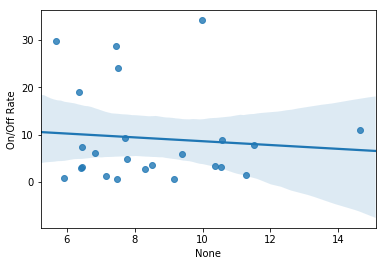

In [196]:
sns.regplot(x=predictions,y=Y.iloc[:,0])

In [189]:
predictions

0      9.816600
1      7.867263
2      8.297475
3     10.688519
4     10.899749
5      8.825854
6      8.929264
7      9.826180
8      9.669614
9      9.205900
10     9.621365
11     8.867868
12     9.646597
13     7.450247
14     9.882811
15     8.099710
16     9.736064
17     7.835984
18     8.005704
19     9.955815
20     9.331369
21    10.620935
22     8.466361
23    10.212754
dtype: float64

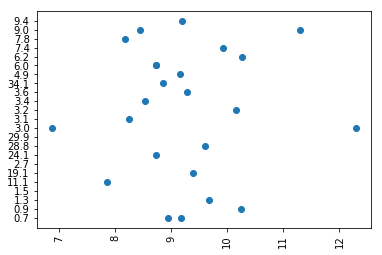

In [108]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.xticks(rotation=90)
#plt.ylim(0,3.5)
#plt.xlim(0,2.5)
plt.scatter(round(predictions.astype(float),2),round(Y.astype(float),1))

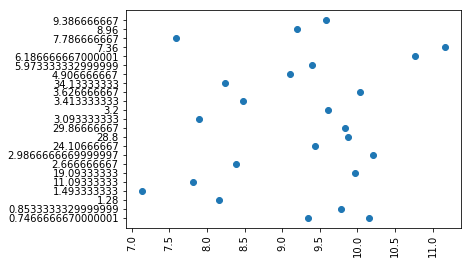

In [121]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.xticks(rotation=90)
#plt.ylim(0,3.5)
#plt.xlim(0,35)
plt.scatter(round(predictions.astype(float),2),Y)

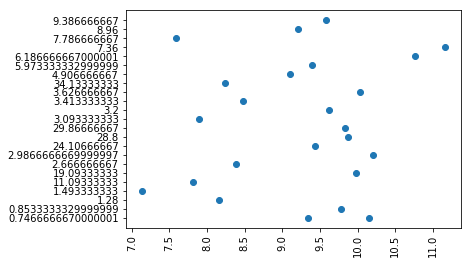

In [124]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.xticks(rotation=90)
#plt.ylim(0,3.5)
#plt.xlim(0,35)
plt.scatter(predictions,Y)

In [106]:
fx=52.06-22.4*Serie_B["Trigger_Deffect"]-54.3*Serie_B["Sensor_Defect"]-15.06*Serie_B["dBIndingSite"]-0.707*Serie_B["Dg_RBS_linker"]

In [ ]:

X = Serie_B[["Sensor_Defect","DeltaG_Trigger"]] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = Serie_B[["On/Off Rate"]] 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

In [ ]:
plt.scatter(12.94282798-15.60454284*Serie_B["Sensor_Defect"],Y)

In [ ]:
Dg_Complex=[]
for i in range(len(a.iloc[:,3])):
    Dg_Complex.append(DG_2(a.iloc[i,2],a.iloc[i,3],"",2))
P4=pd.Series(Dg_Complex)
Serie_B["DeltaG_Complex"]=P4.values

In [ ]:
x=Serie_B.loc[:,"Sensor_Defect"]
y=Serie_B.loc[:,"On/Off Rate"]
print(rsquared(x,y))
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
#plt.xlim(0, 5)
#plt.ylim(0, 12)
#plt.scatter(x ,y)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [ ]:
c=0
for i in ".........................(((((((((((...(((((............)))))...)))))))))))......................":
    print (i,c)
    c=c+1

In [ ]:
a.iloc[11,4][101:(101+len(a.iloc[11,3]))]

In [ ]:
a.iloc[:,2]

In [ ]:
#FInding where starts the sequence of the trigger in the amplifyed sequence
from skbio import Sequence
s = Sequence(a.iloc[11,4])
s.index(a.iloc[11,3])



In [ ]:
plt.scatter(Serie_B.iloc[:,9],Serie_B.iloc[:,1])
plt.xlabel("Trigger Defect")
plt.ylabel("On/Off ratio")

In [ ]:
Serie_B.loc[:,"Trigger_Deffect"]

In [ ]:
LacZ=str("AUGACCAUGAUUACGGAUUCACUGGCCGUCGUUUUACAACGUCGUGACUGGGAAAACCCUGGCGUUACCCAACUUAAUCGCCUUGCAGCACAUCCCCCUUUCGCCAGCUGGCGUAAUAGCGAAGAGGCCCGCACCGAUCGCCCUUCCCAACAGUUGCGCAGCCUGAAUGGCGAAUGGCGCUUUGCCUGGUUUCCGGCACCAGAAGCGGUGCCGGAAAGCUGGCUGGAGUGCGAUCUUCCUGAGGCCGAUACUGUCGUCGUCCCCUCAAACUGGCAGAUGCACGGUUACGAUGCGCCCAUCUACACCAACGUGACCUAUCCCAUUACGGUCAAUCCGCCGUUUGUUCCCACGGAGAAUCCGACGGGUUGUUACUCGCUCACAUUUAAUGUUGAUGAAAGCUGGCUACAGGAAGGCCAGACGCGAAUUAUUUUUGAUGGCGUUAACUCGGCGUUUCAUCUGUGGUGCAACGGGCGCUGGGUCGGUUACGGCCAGGACAGUCGUUUGCCGUCUGAAUUUGACCUGAGCGCAUUUUUACGCGCCGGAGAAAACCGCCUCGCGGUGAUGGUGCUGCGCUGGAGUGACGGCAGUUAUCUGGAAGAUCAGGAUAUGUGGCGGAUGAGCGGCAUUUUCCGUGACGUCUCGUUGCUGCAUAAACCGACUACACAAAUCAGCGAUUUCCAUGUUGCCACUCGCUUUAAUGAUGAUUUCAGCCGCGCUGUACUGGAGGCUGAAGUUCAGAUGUGCGGCGAGUUGCGUGACUACCUACGGGUAACAGUUUCUUUAUGGCAGGGUGAAACGCAGGUCGCCAGCGGCACCGCGCCUUUCGGCGGUGAAAUUAUCGAUGAGCGUGGUGGUUAUGCCGAUCGCGUCACACUACGUCUGAACGUCGAAAACCCGAAACUGUGGAGCGCCGAAAUCCCGAAUCUCUAUCGUGCGGUGGUUGAACUGCACACCGCCGACGGCACGCUGAUUGAAGCAGAAGCCUGCGAUGUCGGUUUCCGCGAGGUGCGGAUUGAAAAUGGUCUGCUGCUGCUGAACGGCAAGCCGUUGCUGAUUCGAGGCGUUAACCGUCACGAGCAUCAUCCUCUGCAUGGUCAGGUCAUGGAUGAGCAGACGAUGGUGCAGGAUAUCCUGCUGAUGAAGCAGAACAACUUUAACGCCGUGCGCUGUUCGCAUUAUCCGAACCAUCCGCUGUGGUACACGCUGUGCGACCGCUACGGCCUGUAUGUGGUGGAUGAAGCCAAUAUUGAAACCCACGGCAUGGUGCCAAUGAAUCGUCUGACCGAUGAUCCGCGCUGGCUACCGGCGAUGAGCGAACGCGUAACGCGAAUGGUGCAGCGCGAUCGUAAUCACCCGAGUGUGAUCAUCUGGUCGCUGGGGAAUGAAUCAGGCCACGGCGCUAAUCACGACGCGCUGUAUCGCUGGAUCAAAUCUGUCGAUCCUUCCCGCCCGGUGCAGUAUGAAGGCGGCGGAGCCGACACCACGGCCACCGAUAUUAUUUGCCCGAUGUACGCGCGCGUGGAUGAAGACCAGCCCUUCCCGGCUGUGCCGAAAUGGUCCAUCAAAAAAUGGCUUUCGCUACCUGGAGAGACGCGCCCGCUGAUCCUUUGCGAAUACGCCCACGCGAUGGGUAACAGUCUUGGCGGUUUCGCUAAAUACUGGCAGGCGUUUCGUCAGUAUCCCCGUUUACAGGGCGGCUUCGUCUGGGACUGGGUGGAUCAGUCGCUGAUUAAAUAUGAUGAAAACGGCAACCCGUGGUCGGCUUACGGCGGUGAUUUUGGCGAUACGCCGAACGAUCGCCAGUUCUGUAUGAACGGUCUGGUCUUUGCCGACCGCACGCCGCAUCCAGCGCUGACGGAAGCAAAACACCAGCAGCAGUUUUUCCAGUUCCGUUUAUCCGGGCAAACCAUCGAAGUGACCAGCGAAUACCUGUUCCGUCAUAGCGAUAACGAGCUCCUGCACUGGAUGGUGGCGCUGGAUGGUAAGCCGCUGGCAAGCGGUGAAGUGCCUCUGGAUGUCGCUCCACAAGGUAAACAGUUGAUUGAACUGCCUGAACUACCGCAGCCGGAGAGCGCCGGGCAACUCUGGCUCACAGUACGCGUAGUGCAACCGAACGCGACCGCAUGGUCAGAAGCCGGGCACAUCAGCGCCUGGCAGCAGUGGCGUCUGGCGGAAAACCUCAGUGUGACGCUCCCCGCCGCGUCCCACGCCAUCCCGCAUCUGACCACCAGCGAAAUGGAUUUUUGCAUCGAGCUGGGUAAUAAGCGUUGGCAAUUUAACCGCCAGUCAGGCUUUCUUUCACAGAUGUGGAUUGGCGAUAAAAAACAACUGCUGACGCCGCUGCGCGAUCAGUUCACCCGUGCACCGCUGGAUAACGACAUUGGCGUAAGUGAAGCGACCCGCAUUGACCCUAACGCCUGGGUCGAACGCUGGAAGGCGGCGGGCCAUUACCAGGCCGAAGCAGCGUUGUUGCAGUGCACGGCAGAUACACUUGCUGAUGCGGUGCUGAUUACGACCGCUCACGCGUGGCAGCAUCAGGGGAAAACCUUAUUUAUCAGCCGGAAAACCUACCGGAUUGAUGGUAGUGGUCAAAUGGCGAUUACCGUUGAUGUUGAAGUGGCGAGCGAUACACCGCAUCCGGCGCGGAUUGGCCUGAACUGCCAGCUGGCGCAGGUAGCAGAGCGGGUAAACUGGCUCGGAUUAGGGCCGCAAGAAAACUAUCCCGACCGCCUUACUGCCGCCUGUUUUGACCGCUGGGAUCUGCCAUUGUCAGACAUGUAUACCCCGUACGUCUUCCCGAGCGAAAACGGUCUGCGCUGCGGGACGCGCGAAUUGAAUUAUGGCCCACACCAGUGGCGCGGCGACUUCCAGUUCAACAUCAGCCGCUACAGUCAACAGCAACUGAUGGAAACCAGCCAUCGCCAUCUGCUGCACGCGGAAGAAGGCACAUGGCUGAAUAUCGACGGUUUCCAUAUGGGGAUUGGUGGCGACGACUCCUGGAGCCCGUCAGUAUCGGCGGAAUUCCAGCUGAGCGCCGGUCGCUACCAUUACCAGUUGGUCUGGUGUCAAAAAUAAAGGU")

In [ ]:
complete_Sensor=[]
for i in range(len((a.iloc[:,4]))):
    complete_Sensor.append(a.iloc[i,2]+ str(LacZ))
p20=complete_Sensor
a["Complete_Sensor"]=p20

In [ ]:
a.iloc[:,9]

In [ ]:
from skbio import Sequence
def ss_in_context(sequence,sub_sequence,result_path, wait=1):
    s = Sequence(sequence)
    initial=s.index(sub_sequence)

    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    
    
    sin=parsed_res[initial:initial+len(sub_sequence)]
    norm=(np.sum(sin)/len(sin))


    return norm

In [ ]:
s = Sequence(a.iloc[11,4])
s.index(a.iloc[11,3])
len(a.iloc[11,4])
b=ss_in_context(a.iloc[11,4],a.iloc[11,3],"",5)
b

In [ ]:
SS_Trigger_in_context=[]
for i in range(len(a.iloc[:,3])):
    print("Calculating" +str(i))
    sin=ss_in_context(a.iloc[i,4],a.iloc[i,3],"",5)
    SS_Trigger_in_context.append(sin)

SS_Trigger_in_context

In [ ]:
p9=pd.Series(SS_Trigger_in_context)
a["SS_Th_in_context"]=p9
a


In [ ]:
p7=pd.Series(SS_Trigger_in_context)
a["SS_Trigger_in_context"]=p7

In [ ]:
a.iloc[:,2]

In [ ]:
t=Sequence(a.iloc[i,2][0:25])
t

In [ ]:
a.iloc[:,9]

In [ ]:
a.iloc[8,9]

In [ ]:
s = Sequence(a.iloc[i,9])
initial=s.index(a.iloc[i,2][0:25])
with open("{}pipo.ppairs".format("")) as res:
    parsed_res = parse_pairs_result(res, len(a.iloc[i,9]))

    os.remove("{}pipo.ppairs".format("",))
    os.remove("{}pipo.in".format(""))
    
    
    sin=parsed_res[initial:initial+len(a.iloc[i,2][0:25])]
    norm=(np.sum(sin)/len(sin))
norm

In [ ]:
SS_Toehold_in_context=[]
for i in range(len(a.iloc[:,3])):
    print("Calculating" +str(i))
    SS_Toehold_in_context.append(ss_pin_context(a.iloc[i,9],a.iloc[i,2][0:25],"",6000))

In [ ]:
SS_Toehold_in_context

In [ ]:
types=[]
for i in range(len(a.iloc[:,3])):
    if (a.iloc[i,2][25])=="C"or (a.iloc[i,2][25])=="G":
        types.append("S")
    else:
        types.append("W")

    print(a.iloc[i,2][25],types[i])  
    

In [ ]:
types_2=[]
for i in range(len(a.iloc[:,3])):
    if (a.iloc[i,2][26])=="C" or (a.iloc[i,2][26])=="G":
        types_2.append("S")
    else:
        types_2.append("W")
    print(a.iloc[i,2][26],types_2[i]) 

In [ ]:
two=[]
for i in range(len(types_2)):
    two.append(types[i] + types_2[i])

In [ ]:
for i in range(len(types_2)):
    print(a.iloc[i,1],two[i])

In [ ]:
p8=pd.Series(types)
a["First_invading"]=p8

In [ ]:
#correlation first analisis
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

plt.figure(figsize=(5,20))

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    pos = (.1, .9) if kws['label'] == 'W' else (.1,.8)
    ax.annotate("r = {:.2f}".format(kws['label'],r),
                xy=pos, xycoords=ax.transAxes)
    



  
    
g = sns.pairplot(a, 
                 y_vars=["On/Off Rate"],
                 x_vars=["SS_Th_in_context","DeltaG_Switch","SS_Trigger_in_context","DeltaG_Complex","DeltaG_Trigger","Dg_RBS_linker","Single_Streadness_Trigger","diff_DG"],
                 hue="First_invading")
                
#g.map(corrfunc)
#plt.show()  
#g.map_diag(sns.distplot, kde=False)
#g.map_lower(sns.kdeplot, cmap="Blues_d")


plt.tight_layout()
plt.savefig("para_B.pdf",dpi=500)



In [ ]:
p9=pd.Series(two)
a["First2_invading"]=p9

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

plt.figure(figsize=(20,20))
c=0
Dg_INv_f=[]
inviding_f=[]
for j in range(len(a.iloc[:,3])):
    Dg_INv=[]
    inviding=[]
    c=j+1
    ax=plt.subplot(6,4,c)
    
    for i in range(13):
        print(a.iloc[j,3][(13-i):])
        Dg_INv.append(DG_2(a.iloc[j,2],a.iloc[j,3][(13-i):],"",2))
        inviding.append(i)
    Dg_INv_f.append(Dg_INv)
    inviding_f.append(j)
    plt.xlabel("Number of invading nucleotides")
    plt.ylabel("Free Energy of the complex")

    plt.plot(inviding,Dg_INv,label="Sensor %s B + Trigger"  % str(a.Sensor[j]))
    plt.legend(loc=0)
#plt.show() 

plt.tight_layout()
plt.savefig("Serie_B.pdf",dpi=500)

In [ ]:
diff_DG=[]
for i in range(len(a.iloc[:,3])):
    diff_DG.append(Dg_INv_f[i][0]-Dg_INv_f[i][-1])
P4=pd.Series(diff_DG)
a["diff_DG"]=P4.values 

In [ ]:
range(24)

In [ ]:
Dg_RBS_linker=[]
for i in range(len(a.iloc[:,3])):
    RBS_linker=a.iloc[i,2][48:96]
    Dg_RBS_linker.append(DG(RBS_linker,"",2))
P11=pd.Series(Dg_RBS_linker)

In [ ]:
a["Dg_RBS_linker"]=P11.values

In [ ]:
a

In [ ]:
plt.gca?

In [ ]:
a
